# Dust Model Inference Luminosity-Color Distribution

The goal of this tutorial is to constrain the parameters of a simplified dust model using galaxy luminosity and color distributions. Using the data provided, we will show how the luminosity, color, and color-luminosity distributions can be used to provide orthogonal constraints on the dust model parameters.


Using [synthesizer](https://github.com/flaresimulations/synthesizer)

In [14]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [2]:
# Load data
dat = pd.read_csv('./data/simulations_colour_lf.txt', sep=' ', header=None)

params = dat.iloc[:, 0:3].values  # dust parameters (tau_ISM, tau_BC, mu)
color = dat.iloc[:, 3:27].values  # color distribution
lumin = dat.iloc[:, 27:36].values  # luminosity distribution
colorlumin = dat.iloc[:, 3:36].values  # color and luminosity distribution vector

binLimsLF = np.linspace(-25, -17, 10) # r-band
binLimsColour = np.linspace(0, 1.3, 25) # g-r
cenLF = (binLimsLF[1:] + binLimsLF[:-1]) / 2
cenColour = (binLimsColour[1:] + binLimsColour[:-1]) / 2

Text(0.5, 1.0, 'Galaxy Color Distribution')

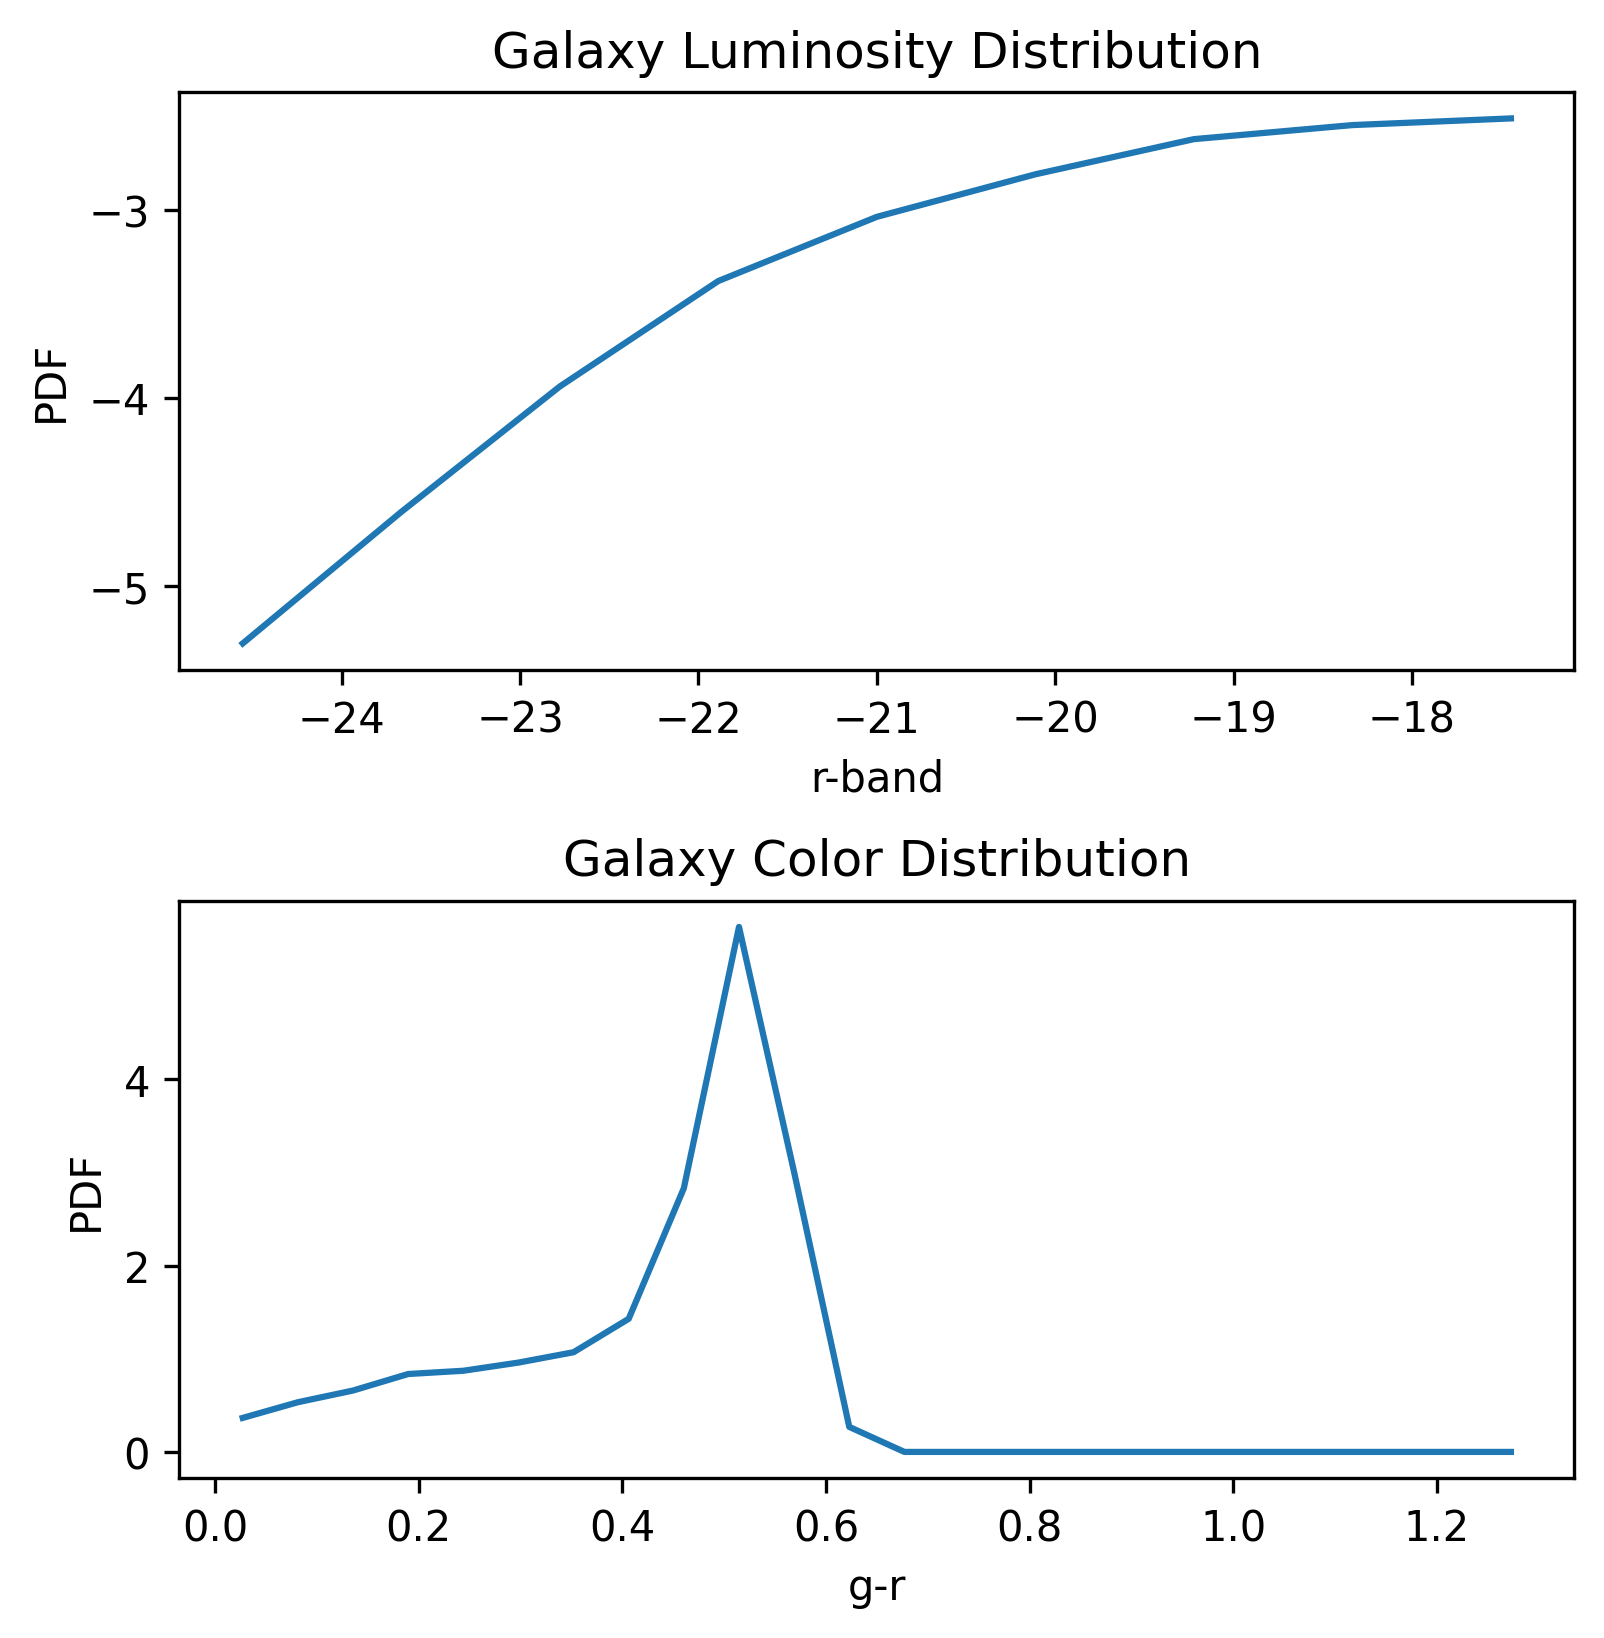

In [3]:
i = np.random.randint(len(params))  # random galaxy

f, axs = plt.subplots(2,1, figsize=(6,6), dpi=300, gridspec_kw={'hspace': 0.4})

# plot galaxy luminosity distribution
axs[0].plot(cenLF, lumin[i])
axs[0].set_xlabel('r-band')
axs[0].set_ylabel('PDF')
axs[0].set_title('Galaxy Luminosity Distribution')

# plot galaxy color distribution
axs[1].plot(cenColour, color[i])
axs[1].set_xlabel('g-r')
axs[1].set_ylabel('PDF')
axs[1].set_title('Galaxy Color Distribution')

In [4]:
# Train/test split
np.random.seed(0)
test_split = 0.1
in_train = np.random.rand(len(params)) > test_split

# Setup dataloaders
train_c = NumpyLoader(x=color[in_train], theta=params[in_train])  # color model
test_c = NumpyLoader(x=color[~in_train], theta=params[~in_train])  # color model

train_l = NumpyLoader(x=lumin[in_train], theta=params[in_train])  # luminosity model
test_l = NumpyLoader(x=lumin[~in_train], theta=params[~in_train])  # luminosity model

train_cl = NumpyLoader(x=colorlumin[in_train], theta=params[in_train])  # color-luminosity model
test_cl = NumpyLoader(x=colorlumin[~in_train], theta=params[~in_train])  # color-luminosity model

In [5]:
# Setup prior
prior = ili.utils.Uniform(
    low=torch.tensor([0.01, 0.4, 0.3]),
    high=torch.tensor([0.6, 2.0, 2.0]),
)

# Training

In [40]:
# Setup Inference Engines (color, luminosity, color-luminosity)

def setup_engine():
    # same engine for all models
    nets = [
        ili.utils.load_nde_lampe(model='maf', hidden_features=50,
                                 num_transforms=5, x_normalize=True),
        ili.utils.load_nde_lampe(model='gf', hidden_features=50,
                                 num_transforms=5, x_normalize=True),
    ]
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 5e-5
    }
    return InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )

trainer_c = setup_engine()
trainer_l = setup_engine()
trainer_cl = setup_engine()

In [7]:
# Train the models

posterior_c, summary_c = trainer_c(train_c)
posterior_l, summary_l = trainer_l(train_l)
posterior_cl, summary_cl = trainer_cl(train_cl)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


659 epochs [01:04, 10.26 epochs/s, loss=-5.08, loss_val=-4.84] 
INFO:root:It took 64.2563042640686 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
948 epochs [01:32, 10.29 epochs/s, loss=-5.49, loss_val=-5.11] 
INFO:root:It took 92.11005210876465 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.
513 epochs [00:47, 10.81 epochs/s, loss=-8.88, loss_val=-7.86]   
INFO:root:It took 47.44741606712341 seconds to train models.


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Validation Log Probability')]

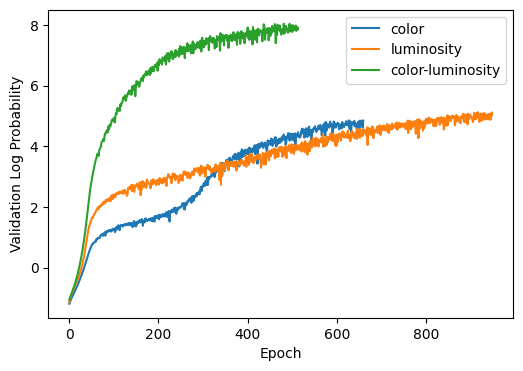

In [8]:
# Plot Loss
f, ax = plt.subplots(1,1, figsize=(6,4))

labels = ['color', 'luminosity', 'color-luminosity']
for i, (l, s) in enumerate(zip(labels, [summary_c, summary_l, summary_cl])):
    for t in s:
        ax.plot(t['validation_log_probs'], label=l, c=f'C{i}')
ax.legend()
ax.set(xlabel='Epoch', ylabel='Validation Log Probability')

# Validation

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1657it [00:00, 11902.03it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1742it [00:00, 13978.95it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1890it [00:00, 15503.77it/s]            


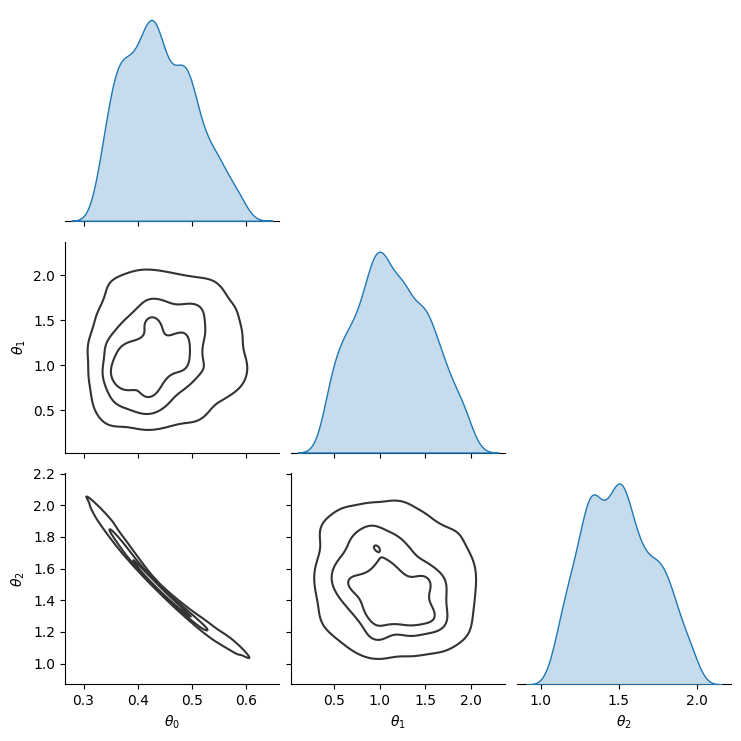

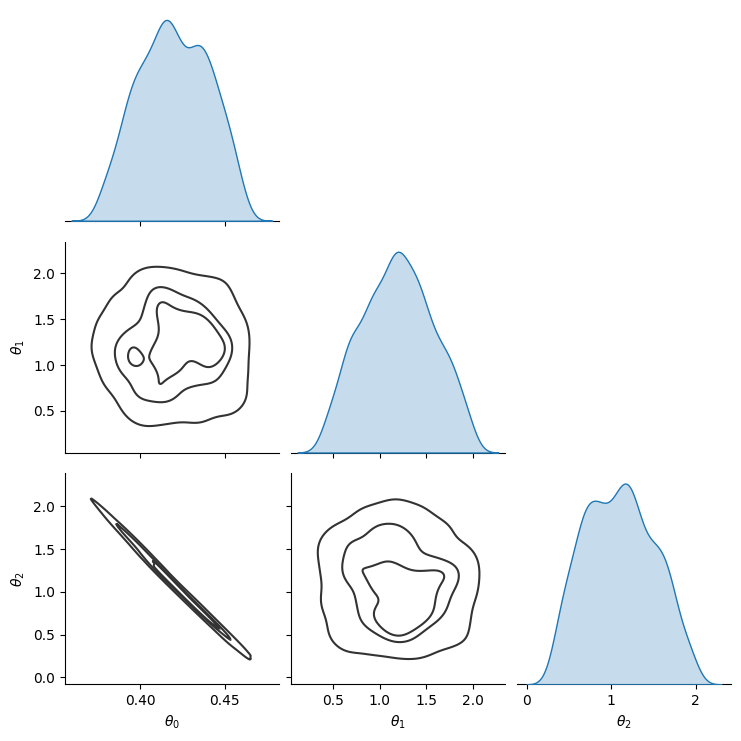

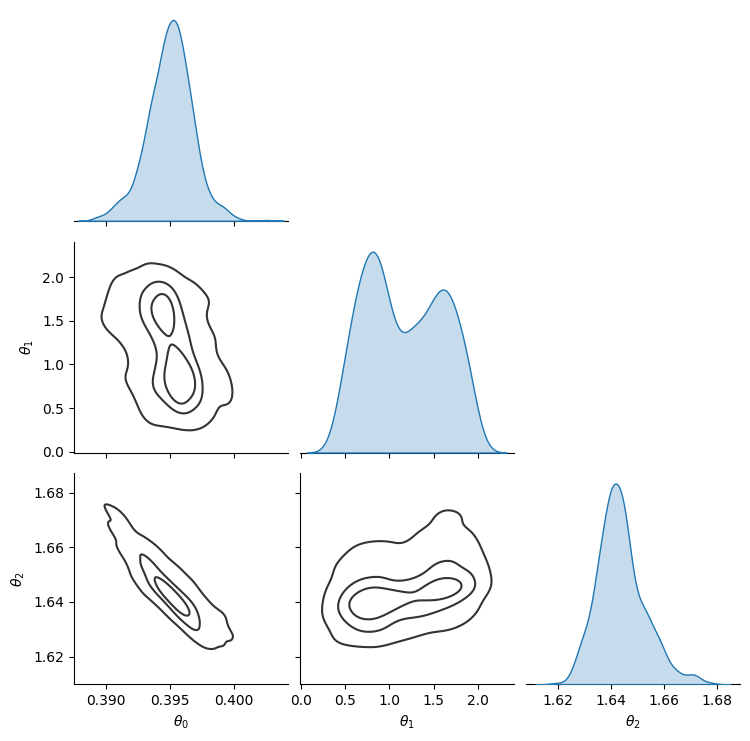

In [9]:
# Run Validation
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)

ind = np.random.choice(np.argwhere(~in_train).flatten(), 1)[0]
x_c = color[ind]
x_l = lumin[ind]
x_cl = colorlumin[ind]
metric(posterior_c, x_obs=x_c)
metric(posterior_l, x_obs=x_l)
metric(posterior_cl, x_obs=x_cl)

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1692it [00:00, 12882.48it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1819it [00:00, 14406.20it/s]            
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1890it [00:00, 14954.90it/s]            


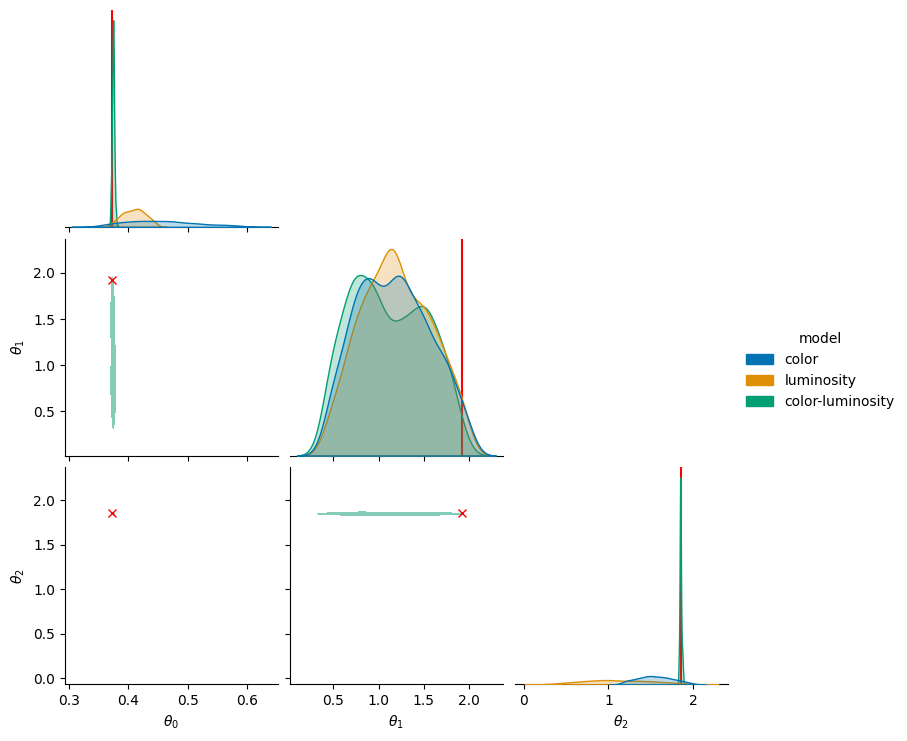

In [39]:
# Choose a random input
np.random.seed(0)
ind = np.random.choice(np.argwhere(~in_train).flatten(), 1)[0]
x_c = color[ind]
x_l = lumin[ind]
x_cl = colorlumin[ind]
true = params[ind]

# Sample from the posterior
Nsamps = 1000
samps_c = posterior_c.sample(x=x_c, shape=(Nsamps,))
samps_l = posterior_l.sample(x=x_l, shape=(Nsamps,))
samps_cl = posterior_cl.sample(x=x_cl, shape=(Nsamps,))

# Plot corner with seaborn
samps = torch.cat([samps_c, samps_l, samps_cl], dim=0).detach().cpu().numpy()
samps = pd.DataFrame(samps, columns=[f'$\\theta_{i}$' for i in range(3)])
samps['model'] = ''
samps.loc[:Nsamps, 'model'] = 'color'
samps.loc[Nsamps:2*Nsamps, 'model'] = 'luminosity'
samps.loc[2*Nsamps:, 'model'] = 'color-luminosity'

g = sns.pairplot(samps, hue='model', palette='colorblind', kind='kde',
                 corner=True, 
                 plot_kws=dict(
                     fill=True, alpha=0.5, levels=[0.32, 1],
                 ))
for i in range(3):
    for j in range(3):
        if i > j:
            g.axes[i,j].plot(true[j], true[i], c='r', marker='x')
        elif i == j:
            g.axes[i,j].axvline(true[i], c='r')

In [29]:
ind

309